# **Data visualisation**

## Objectives

* Plot images width and height.

To tackle business case 1:
* Plot averages of all images in each class.
* Create a variability plot showing variability between the healthy and powdery_mildew images.
* Plot differences between average healthy and powdery mildew cherry leaves.
* Create montage to provide a visual representation of the images in different classes side-by-side to the client.

## Inputs

* inputs/cherry_leaves_dataset/cherry-leaves/train/healthy
* inputs/cherry_leaves_dataset/cherry-leaves/train/powdery_mildew

## Outputs

* Output image shape as pickle file for use in model training.
* Average images and variabilities for each class.
* A plot of the difference of average between classes.
* An image montage for each class.

---

# Import packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import joblib
sns.set_style("white")

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [2]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/project-5/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
current_dir = os.getcwd()
current_dir

'/workspaces/project-5'

---

# Set input directories

In [5]:
data_dir = 'inputs/cherry_leaves_dataset/cherry-leaves'
train_dir = data_dir + '/train'

# Set output directory

In [6]:
version_num = 'v1'
output_dir = f'outputs/{version_num}'

if os.path.exists(output_dir):
    print('Output already exists - please pick a new version number if you want to create a new output directory')
else:
    os.makedirs(output_dir)
    print(f'Output {version_num} created')

Output v1 created


# Set label names

In [7]:
labels = os.listdir(train_dir)
print('Image labels are: ', labels)

Image labels are:  ['healthy', 'powdery_mildew']


# Plot image shape

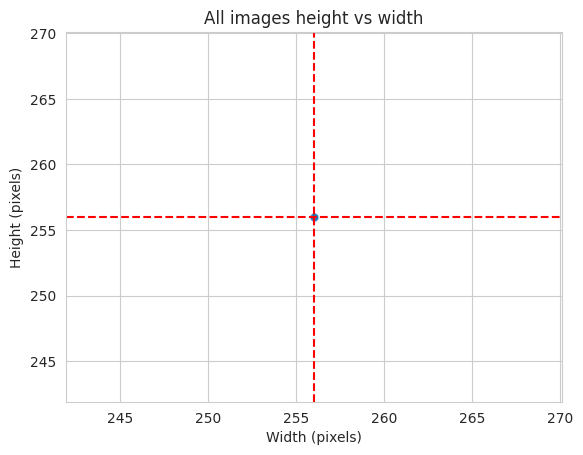

The average width of the images are 256 and the average height is 256


In [8]:
import matplotlib.image as mpimg

# set empty lists to store image height and width
img_width, img_height = [], []

# iterate through each class
for label in labels:
    files_folder = train_dir + '/' + label
    file_list = os.listdir(files_folder)

    # iterate through files
    for file in file_list:

        file_path = os.path.join(files_folder, file)
        image = mpimg.imread(file_path)
        height, width, color = image.shape
        img_height.append(height)
        img_width.append(width)

sns.set_style("whitegrid")
fig, axes = plt.subplots()
plt.title('All images height vs width')
sns.scatterplot(x=img_width, y=img_height, alpha=0.3)
plt.xlabel("Width (pixels)")
plt.ylabel("Height (pixels)")
height_mean = int(sum(img_height) / len(img_height))
width_mean = int(sum(img_width) / len(img_width))
axes.axvline(x=width_mean, color='r', linestyle='--')
axes.axhline(y=height_mean, color='r', linestyle='--')
plt.show()
print(f"The average width of the images are {width_mean} and the average height is {height_mean}")


In [9]:
image_shape = (height_mean, width_mean, 3)
image_shape

(256, 256, 3)

## Save image shape

In [10]:
joblib.dump(value=image_shape,
            filename=f"outputs/{version_num}/image_shape.pkl")

['outputs/v1/image_shape.pkl']

# Load images into an array

In [11]:
import numpy as np


def load_imgs_as_array(data_dir, new_size=(40, 40), num_images_per_label=20):

    """
    Load images into a numpy array
    Resize images
    """

    X, y = np.array([], dtype='int'), np.array([], dtype='object')

    for label in labels:
        num_interations = 0

        # Defines the directory path where the images are located
        files_folder = train_dir + '/' + label
        file_list = os.listdir(files_folder)

        for file in file_list:
            # Control array size by num_images_per_label or it will take too much time
            if num_interations < num_images_per_label:

                file_path = os.path.join(files_folder, file)

                img = mpimg.imread(file_path)

                if img.max() > 1:
                    img_resized = img / 255
                else:
                    img_resized = img

                X = np.append(X, img_resized).reshape(-1, new_size[0], new_size[1], img_resized.shape[2])
                y = np.append(y, label)
                num_interations += 1

    return X, y

In [12]:
X, y = load_imgs_as_array(data_dir=train_dir, new_size=image_shape, num_images_per_label=30)
print(X.shape, y.shape)

(60, 256, 256, 3) (60,)


## Plot mean variability of images per label

In [13]:
def plot_mean_variability_per_label(X, y, figsize=(12, 5), save_image=False):

    """
    Calculates and plots the mean and standard deviation of the images
    Saves the image if save_image = True
    """

    for presented_label in np.unique(y):
        sns.set_style('white')

        y = y.reshape(-1, 1, 1)

        mask = np.any(y == presented_label, axis=1).reshape(-1)
        array = X[mask]

        average_img = np.mean(array, axis=0)
        stdev_img = np.std(array, axis=0)

        print(f"=== Label {presented_label} ===")
        print(f"Image shape: {average_img.shape}")
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)

        axes[0].set_title(f"Average image for label {presented_label}")
        axes[0].imshow(average_img, cmap='gray')
        axes[1].set_title(f"Variability image for label {presented_label}")
        axes[1].imshow(stdev_img, cmap='gray')

        if save_image:
            plt.savefig(f"{output_dir}//avg_var_{presented_label}.png", bbox_inches='tight', dpi=150)
        else:
            plt.tight_layout()
            plt.show()
            print('\n')


=== Label healthy ===
Image shape: (256, 256, 3)
=== Label powdery_mildew ===
Image shape: (256, 256, 3)


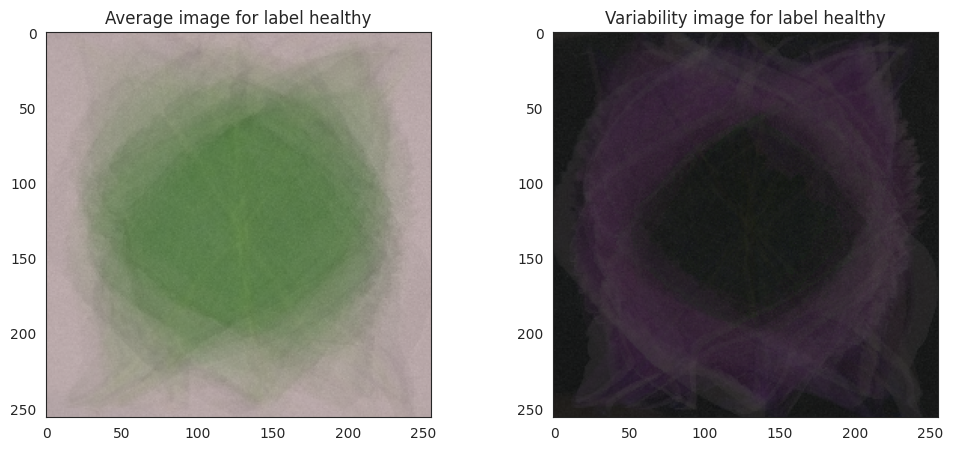

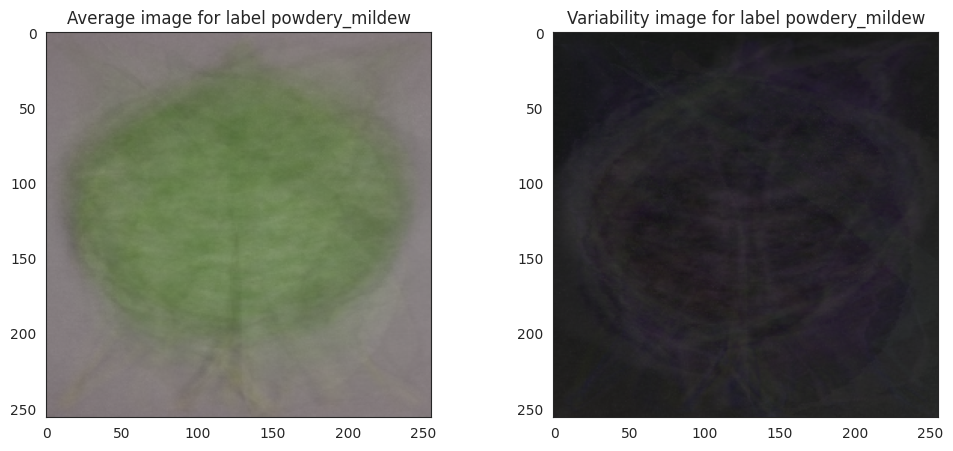

In [14]:
plot_mean_variability_per_label(X=X, y=y, figsize=(12, 5), save_image=True)

## Plot difference of average images between classes

In [15]:
def subset_image_label(X, y, presented_label):
    y = y.reshape(-1, 1, 1)
    mask = np.any(y == presented_label, axis=1).reshape(-1)
    df = X[mask]
    return df


def diff_bet_avg_images_array(X, y, label1, label2, figsize=(20, 5), save_image=False):

    """
    Checks existence of labels in the set of unique labels
    Calculates the mean and difference between the means between label1 and label2
    Plot the graphs and saves them on the conditions if save_image=True
    """

    if any(label not in np.unique(y) for label in [label1, label2]):
        print(f"Either label {label1} or {label2}, are not in {np.unique(y)}")
        return

    # calculate mean from label1
    images_label = subset_image_label(X, y, label1)
    label1_avg = np.mean(images_label, axis=0)

    # calculate mean from label2
    images_label = subset_image_label(X, y, label2)
    label2_avg = np.mean(images_label, axis=0)

    # calculate and plot difference in mean between label1 and label2
    diff = label1_avg - label2_avg

    sns.set_style("white")

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=figsize)

    axes[0].imshow(label1_avg, cmap='gray')
    axes[0].set_title(f"Average {label1}")

    axes[1].imshow(label2_avg, cmap='gray')
    axes[1].set_title(f"Average {label2}")

    axes[2].imshow(diff, cmap='gray')
    axes[2].set_title(f"Difference image: Average {label2} \n"
                      f"& {label1}")

    if save_image:
        plt.savefig(f"{output_dir}/avg_diff.png", bbox_inches='tight', dpi=150)
    else:
        plt.tight_layout()
        plt.show()
        print('\n')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


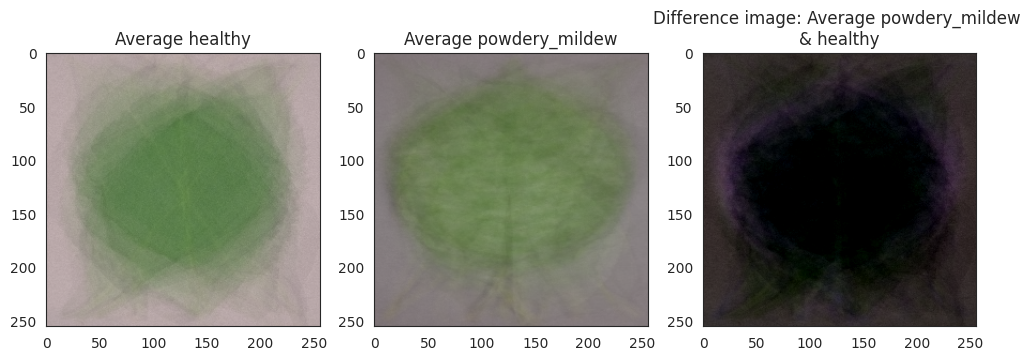

In [16]:
diff_bet_avg_images_array(X=X, y=y, label1='healthy', label2='powdery_mildew',
                          figsize=(12,10), save_image=True)

## Create montage

In [17]:
import itertools
import random
sns.set_style("darkgrid")


def create_image_montage(dir_path, presented_label, num_rows, num_cols, figsize=(15, 10)):

    """
    Check if label exists in specified directory
    Check if size of montage exceeds the subset size
    Generate a list of axes indices based on subset size
    Loop through images and plot them
    Limit the number of images plotted by predefined size of figure
    """

    fig_grid = num_rows * num_cols

    if presented_label in labels:
        img_lst = os.listdir(dir_path + '/' + label)

        if fig_grid < len(img_lst):
            # select random image
            img_idx = np.random.choice(img_lst, num_rows * num_cols)

        else:
            print(f'There are {len(img_lst)} in your subset..\n'
                  f'but you requested a montage with {nrows * ncols} spaces. \n'
                  f'Decrease your number of cols or number of rows in your requested montage')
            return

        # create list of axes indices based on num_rows and num_cols
        lst_rows = range(0, num_rows)
        lst_cols = range(0, num_cols)
        plot_idx = list(itertools.product(lst_rows, lst_cols))

        # create plot and display images
        fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=figsize)

        for x in range(0, fig_grid):
            img = imread(dir_path + '/' + presented_label + '/' + img_idx[x])
            img_shape = img.shape
            axes[plot_idx[x][0], plot_idx[x][1]].imshow(img)
            axes[plot_idx[x][0], plot_idx[x][1]].set_title(f"Width {img_shape[1]}px x Height {img_shape[0]}px")
            axes[plot_idx[x][0], plot_idx[x][1]].set_xticks([])
            axes[plot_idx[x][0], plot_idx[x][1]].set_yticks([])
        plt.tight_layout()
        plt.show()

    else:
        print("The label you selected doesn't exist")
        print(f"Label options are: {labels}")
        return


healthy


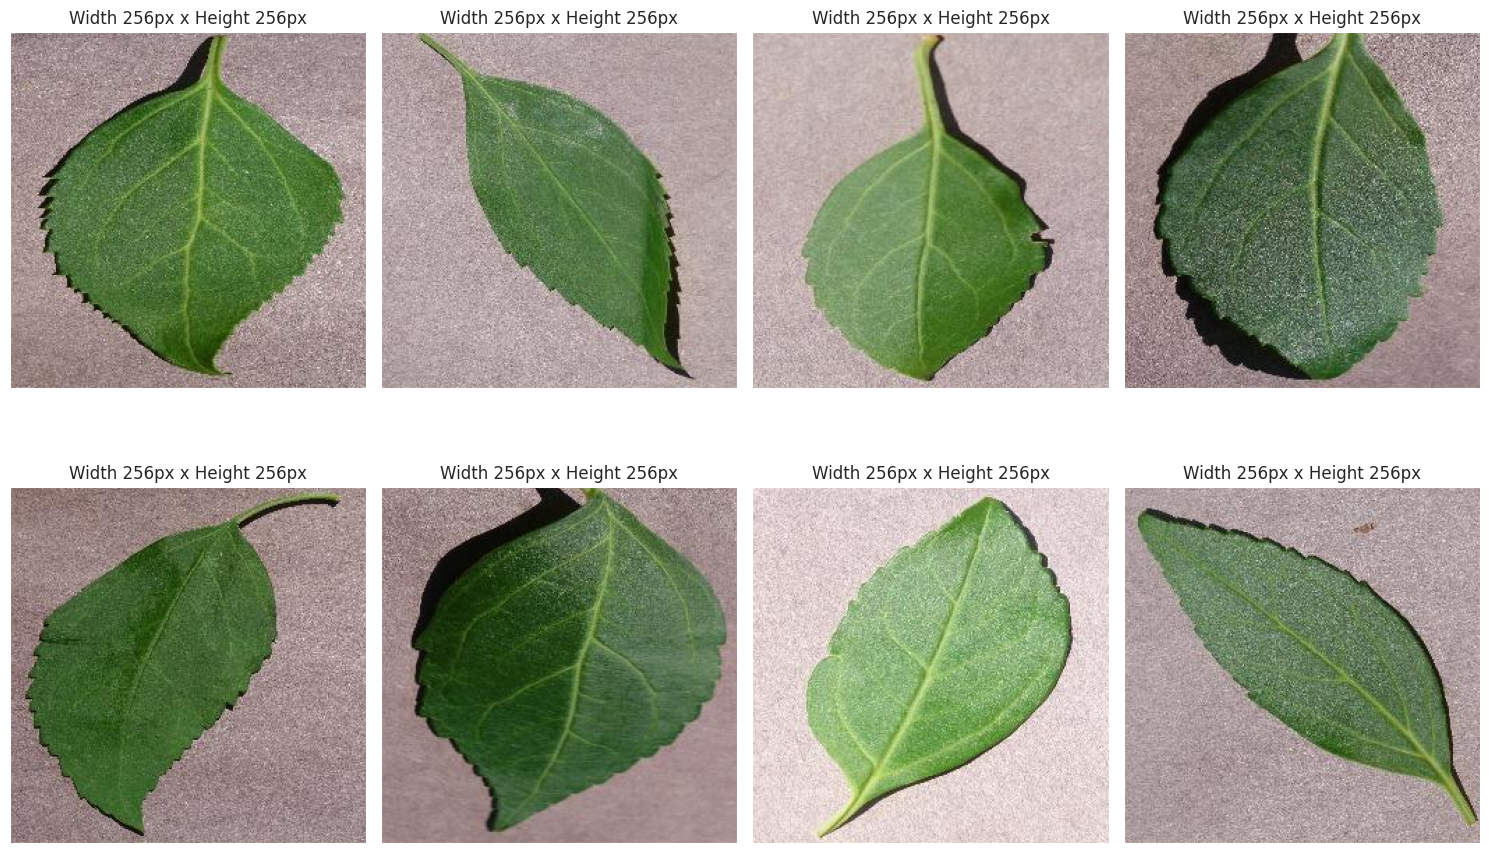

powdery_mildew


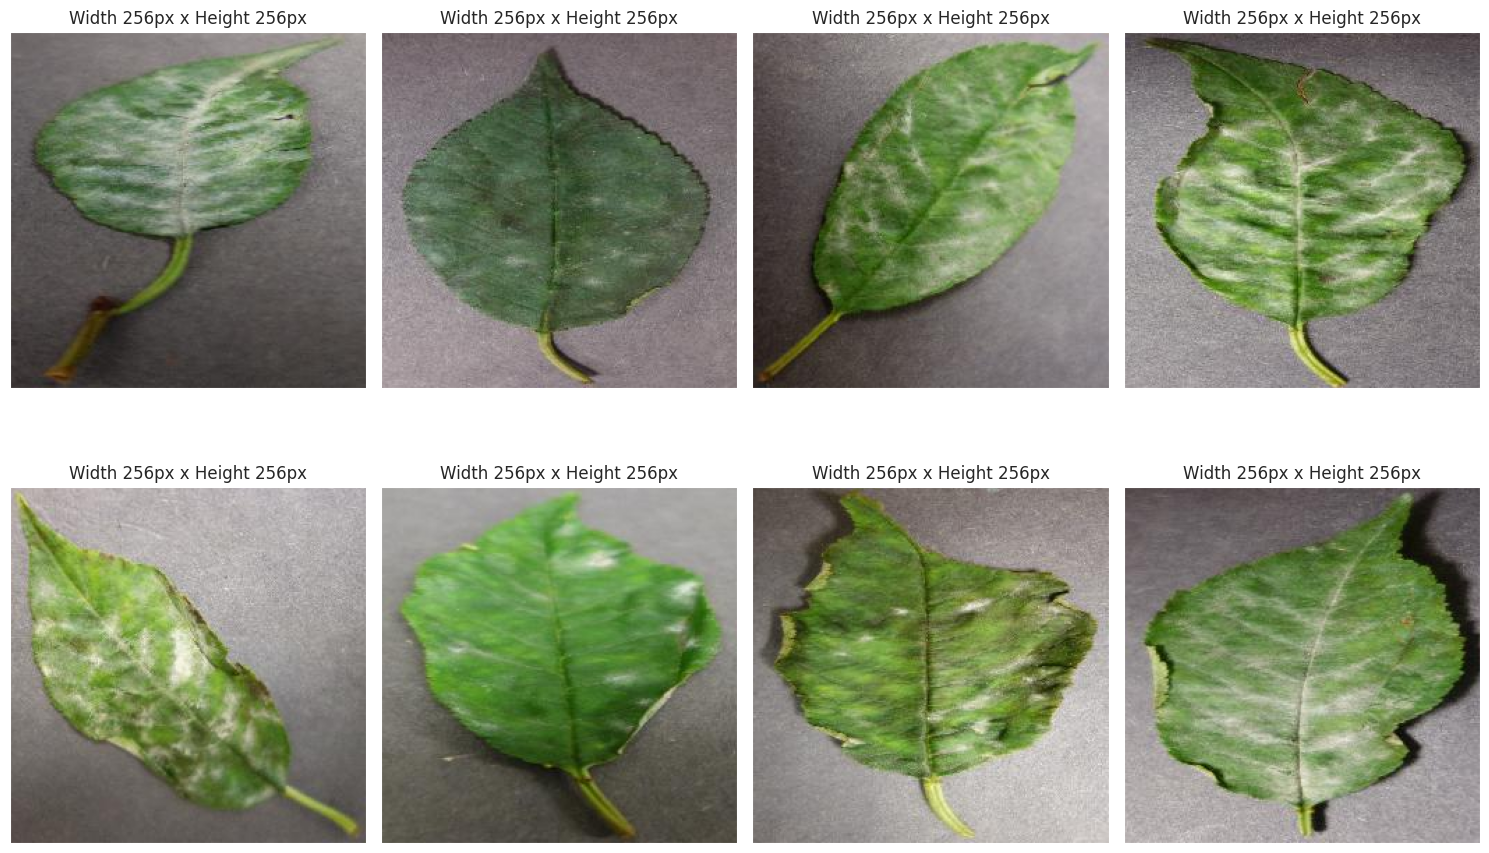

In [18]:
for label in labels:
    print(label)
    create_image_montage(train_dir, label, num_rows=2, num_cols=4, figsize=(15, 10))